# Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией)

## 2. Создание бейзлайна и оценка качества

#### a.	Обучить модели из sklearn (для логистической и линейной регрессий) для выбранных наборов данных

Нужные библиотеки:

In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.spatial import distance
from collections import Counter

#### Работа с данными

In [10]:
wine_data = pd.read_csv('../data/wine_data.csv')

wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)

# Если были пропущенные значения
imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)

y_log = wine_data["IsGood"]
y_lin = wine_data["quality"]

x_train, x_test, y_train_log, y_test_log = train_test_split(x_data, y_log, test_size=0.2, random_state=42)
x_train, x_test, y_train_lin, y_test_lin = train_test_split(x_data, y_lin, test_size=0.2, random_state=42)


Для упрощения работы создадим универсальные функции:

In [11]:
def test_model_log(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"LogisticRegression:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
        cmap="Greys", annot=True, fmt="d", 
        xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"]
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion matrix")
    plt.show()
    
    return model, y_pred

def test_model_lin(model, X_train,X_test, y_train,  y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"LinearRegression:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test, y_pred)}")
    print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")
    
    return model, y_pred

#### Обучение и оценка моделей

LogisticRegression:
Accuracy: 0.859375
F1-score: 0.3283582089552239


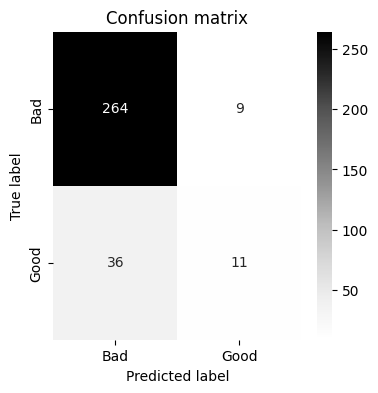

LinearRegression:
Mean Absolute Error (MAE): 0.5035304415524375
Root Mean Squared Error (RMSE): 0.6245199307980125
R-squared (R^2): 0.4031803412796229


In [12]:
_, y_std_pred_log = test_model_log(LogisticRegression(max_iter=1000),
    x_train, x_test, y_train_log, y_test_log
)

_, y_std_pred_lin = test_model_lin(LinearRegression(),
    x_train, x_test, y_train_lin, y_test_lin
)


---
## 3. Улучшение бейзлайна

#### a.	Сформулировать гипотезы (препроцессинг данных, визуализация данных, формирование новых признаков, подбор гиперпараметров на кросс-валидации и т.д.)

Проверим 3 гипотезы для увеличения качества оценки качества вина:

1. Масштабирование признаков
2. Формирование новых признаков
3. Подбор гиперпараметров

#### b.	Проверить гипотезы


##### Масштабируем данные

LogisticRegression:
Accuracy: 0.865625
F1-score: 0.37681159420289856


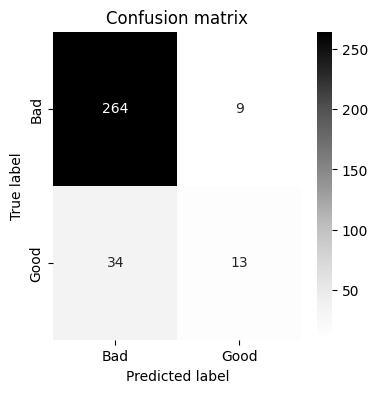

LinearRegression:
Mean Absolute Error (MAE): 0.5035304415524375
Root Mean Squared Error (RMSE): 0.624519930798013
R-squared (R^2): 0.4031803412796219


In [13]:
scaler_std = StandardScaler()
scaled_x_train = scaler_std.fit_transform(x_train)
scaled_x_test = scaler_std.transform(x_test)

_ = test_model_log(LogisticRegression(max_iter=1000),
    scaled_x_train,scaled_x_test,y_train_log,y_test_log
)

_ = test_model_lin(LinearRegression(),
    scaled_x_train,scaled_x_test,y_train_lin,y_test_lin
)

##### Добавление новых признаков, на основе старых данных

LogisticRegression:
Accuracy: 0.8625
F1-score: 0.35294117647058826


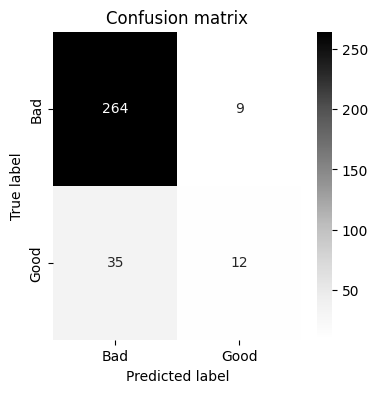

LinearRegression:
Mean Absolute Error (MAE): 0.5035304415524378
Root Mean Squared Error (RMSE): 0.6245199307980128
R-squared (R^2): 0.4031803412796221


In [14]:
x_data_new_features = x_data.copy()

x_data_new_features['bound_so2'] = x_data_new_features['total sulfur dioxide'] - x_data_new_features['free sulfur dioxide']
x_data_new_features['other_acidity'] = x_data_new_features['fixed acidity'] - x_data_new_features['volatile acidity'] - x_data_new_features['citric acid']

_ = test_model_log(LogisticRegression(max_iter=1000),
    *train_test_split(x_data_new_features, y_log, test_size=0.2, random_state=42)
)

_ = test_model_lin(LinearRegression(),
    *train_test_split(x_data_new_features, y_lin, test_size=0.2, random_state=42)
)

##### Подбор гиперпараметров

LogisticRegression:
Accuracy: 0.8625
F1-score: 0.37142857142857144


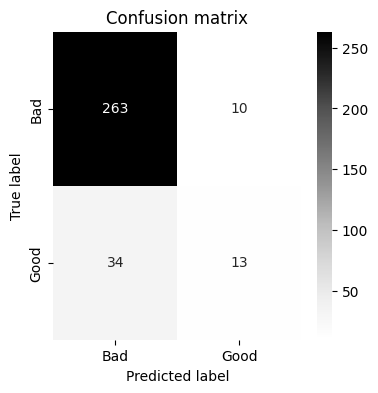

Best parameters: {'C': 10, 'intercept_scaling': 0.001, 'solver': 'lbfgs'}

LinearRegression:
Mean Absolute Error (MAE): 0.5069769126847546
Root Mean Squared Error (RMSE): 0.6266550478538887
R-squared (R^2): 0.39909253548801127
Best parameters: {'alpha': 100}



In [24]:
grid_params = {
    'C': [0.001, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'intercept_scaling': [0.001, 0.1, 1],
}

grid_log = GridSearchCV(LogisticRegression(max_iter=1000), grid_params, scoring='accuracy')
grid_log, y_pred_log = test_model_log(grid_log,
    scaled_x_train, scaled_x_test, y_train_log, y_test_log
)
print(f"Best parameters: {grid_log.best_params_}")
print()

grid_params = {
    'alpha': [0.1, 1, 10, 100, 1000],
}

# LinearRegression() не умеет в параметры, поэтому заменил на Ridge()
grid_lin = GridSearchCV(Ridge(), grid_params, scoring='r2')
grid_lin, y_pred_lin = test_model_lin(grid_lin,
    scaled_x_train, scaled_x_test, y_train_lin, y_test_lin
)
print(f"Best parameters: {grid_lin.best_params_}")
print()

#### c-е.	Сформирован улучшенный бейзлайн по результатам проверки гипотез

Обучить модели с улучшенным бейзлайном (для классификации и регрессии) для выбранных наборов данных
Оценить качество моделей с улучшенным бейзлайном (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.865625
F1-score: 0.37681159420289856


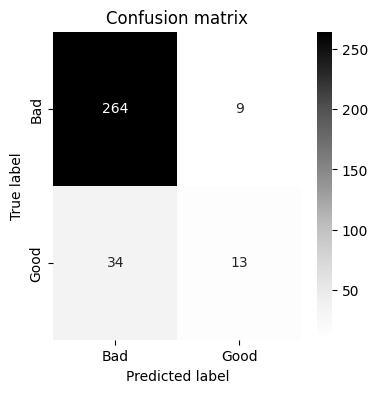

LinearRegression:
Mean Absolute Error (MAE): 0.5035596204290794
Root Mean Squared Error (RMSE): 0.6245302281832383
R-squared (R^2): 0.4031606598177524


In [31]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
y_log = wine_data["IsGood"]
y_lin = wine_data["quality"]

x_train, x_test, y_train_log, y_test_log = train_test_split(x_data, y_log, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

_, y_baseline_pred_log = test_model_log(
    LogisticRegression(max_iter=1000),
    x_train, x_test, y_train_log, y_test_log
)

_, y_baseline_pred_lin = test_model_lin(
    Ridge(),
    x_train, x_test, y_train_lin, y_test_lin
)

#### f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2 

In [32]:
def print_diff(y_test_log, y_pred_log, y_old_pred_log, y_test_lin, y_pred_lin, y_old_pred_lin):
    print(f"Classification:")
    print(f"Increase between old and new predictions classifier:")
    print(f"Accuracy: {accuracy_score(y_test_log, y_pred_log)-accuracy_score(y_test_log, y_old_pred_log)}")
    print(f"F1-score: {f1_score(y_test_log, y_pred_log)-f1_score(y_test_log, y_old_pred_log)}")
    print()
    print(f"Regression:")
    print(f"Increase between old and new predictions regressor:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_lin, y_pred_lin)-mean_absolute_error(y_test_lin, y_old_pred_lin)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test_lin, y_pred_lin) - root_mean_squared_error(y_test_lin, y_old_pred_lin)}")
    print(f"R-squared: {r2_score(y_test_lin, y_pred_lin)-r2_score(y_test_lin, y_old_pred_lin)}")

print_diff(y_test_log, y_baseline_pred_log, y_std_pred_log, y_test_lin, y_baseline_pred_lin, y_std_pred_lin)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.006249999999999978
F1-score: 0.048453385247674674

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: 2.9178876641888785e-05
Root Mean Squared Error (RMSE): 1.029738522584367e-05
R-squared: -1.968146187047992e-05


#### g.	Сделать выводы

##### Классификация:
Обновлённая модель классификации продемонстрировала улучшение качества:  
- **Accuracy** увеличился на **+0.0062**, что указывает на повышение доли правильно классифицированных примеров.  
- **F1-score** значительно вырос на **+0.0484**, что свидетельствует об улучшении баланса между точностью и полнотой, особенно в условиях несбалансированных классов.  

Эти изменения показывают, что модель стала более точной и лучше справляется с задачей классификации.

##### Регрессия:
Обновлённая модель регрессии также показала улучшение:  
- **Mean Absolute Error (MAE)** увеличилась на **2.9178-05**, что означает увеличение среднего отклонения предсказаний от реальных значений.  
- **Root Mean Squared Error (RMSE)** увеличилась на **1.029-05**, указывая на увеличение крупных ошибок в прогнозировании.  
- **R-squared** уменьшился на **-1.968-05**, что свидетельствует о незначительном уменьшении доли объяснённой моделью вариативности данных.  

Эти изменения показывают, что модель стала чуть хуже прогнозировать точные значения качества вина.  


---

## 4.	Имплементация алгоритма машинного обучения 

#### a.	Самостоятельно имплементировать алгоритмы машинного обучения (для классификации и регрессии)

Классификация:

In [67]:
class LogRegression:
    def __init__(self, learn_rate=0.01, max_iter=1000):
        self.learn_rate = learn_rate
        self.max_iter = max_iter
        self.w = None
        self.b = None
        self.mean = None
        self.std = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, x_train, y_train):
        self.mean = np.mean(x_train, axis=0)
        self.std = np.std(x_train, axis=0)
        x_train = (x_train - self.mean) / (self.std + 1e-8)
        samples, features = x_train.shape
        self.w = np.zeros(features)
        self.b = 0
        for _ in range(self.max_iter):
            lin = np.dot(x_train, self.w) + self.b
            y_pred = self.sigmoid(lin)
            error = y_pred - y_train
            
            dw = (1 / samples) * np.dot(x_train.T, error)
            db = (1 / samples) * np.sum(error)
            
            self.w -= self.learn_rate * dw
            self.b -= self.learn_rate * db
    
    def predict_proba(self, x_test):
        x_test = (x_test - self.mean) / (self.std + 1e-8)
        lin = np.dot(x_test, self.w) + self.b
        return self.sigmoid(lin)
    
    def predict(self, x_test, threshold=0.5):
        y_pred_proba = self.predict_proba(x_test)
        return (y_pred_proba >= threshold).astype(int)

Регрессия:

In [64]:
class LinRegression:
    def __init__(self, learn_rate=0.01, max_iter=1000):
        self.learn_rate = learn_rate
        self.max_iter = max_iter
        self.w = None
        self.mean = None
        self.std = None
    
    def fit(self, x_train, y_train):
        self.mean = np.mean(x_train, axis=0)
        self.std = np.std(x_train, axis=0)
        x_train = (x_train - self.mean) / (self.std + 1e-8)
        x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        self.w = np.zeros(x_train.shape[1])

        for i in range(self.max_iter):
            y_pred = np.dot(x_train, self.w)
            err = y_pred - y_train
            grad = np.dot(x_train.T, err) / len(y_train)
            self.w -= self.learn_rate * grad

    def predict(self, x_test):
        x_test = (x_test - self.mean) / (self.std + 1e-8)
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
        return np.dot(x_test, self.w)

#### b-с.	Обучить имплементированные модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество имплементированных моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

Классификация:

LogisticRegression:
Accuracy: 0.8625
F1-score: 0.3125


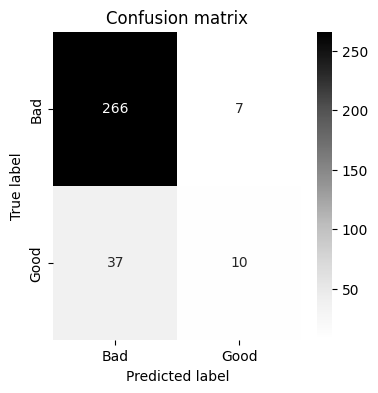

In [69]:
_, y_custom_pred_log = test_model_log(LogRegression(),
    *train_test_split(x_data, y_log, test_size=0.2, random_state=42)
)

Регрессия:

In [70]:
_ , y_custom_pred_lin = test_model_lin(LinRegression(),
    *train_test_split(x_data,y_lin,test_size=0.2,random_state=42)
)

LinearRegression:
Mean Absolute Error (MAE): 0.5034988856461131
Root Mean Squared Error (RMSE): 0.6244104994848448
R-squared (R^2): 0.40338947803804714


#### d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2 

In [71]:
print_diff(
    y_test_log, y_custom_pred_log,y_std_pred_log,
    y_test_lin,y_custom_pred_lin,y_std_pred_lin
)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.0031250000000000444
F1-score: -0.015858208955223885

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -3.1555906324420846e-05
Root Mean Squared Error (RMSE): -0.00010943131316765164
R-squared: 0.0002091367584242665


#### e.	Сделать выводы

Классификация:

- Accuracy: Увеличение на 0.0031 (0.31%). Это незначительное улучшение точности модели, которое может быть полезным, но практически малозаметным.
- F1-score: Уменьшение на 0.0159 (-1.59%). Снижение F1-score указывает на ухудшение баланса между точностью и полнотой, что особенно важно при работе с несбалансированными данными.

Итог: Несмотря на небольшое улучшение точности, снижение F1-score делает кастомную модель менее предпочтительной для задачи классификации.

Регрессия:

- Mean Absolute Error (MAE): Уменьшение на 0.00003. Изменение крайне мало, практически на уровне шума.
- Root Mean Squared Error (RMSE): Уменьшение на 0.00011. Похожая ситуация — изменение слишком незначительное для практического применения.
- R-squared: Увеличение на 0.00021. Незначительное улучшение объяснённой дисперсии, которое также мало влияет на общую производительность модели.

Итог: Для задачи регрессии кастомная модель показывает минимальные изменения в лучшую сторону, которые практически не влияют 
на результат.

#### f-h.	Добавить техники из улучшенного бейзлайна (пункт 3с)

Обучить модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.8625
F1-score: 0.3125


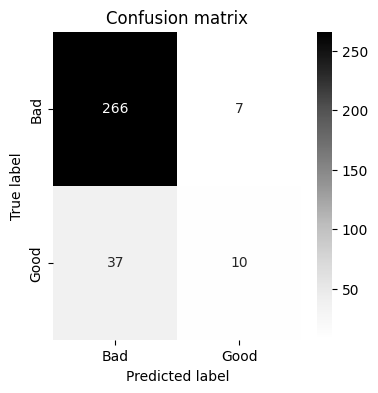

LinearRegression:
Mean Absolute Error (MAE): 0.5034988855637661
Root Mean Squared Error (RMSE): 0.6244105000770059
R-squared (R^2): 0.4033894769064532


In [72]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
y_log = wine_data["IsGood"]
y_lin = wine_data["quality"]

x_train, x_test, y_train_log, y_test_log = train_test_split(x_data, y_log, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

_, y_custom_baseline_pred_log = test_model_log(
    LogRegression(),
    x_train, x_test, y_train_log, y_test_log
)

_, y_custom_baseline_pred_lin = test_model_lin(
    LinRegression(),
    x_train, x_test, y_train_lin, y_test_lin
)

#### i.	Сравнить результаты моделей в сравнении с результатами из пункта 3

In [73]:
print_diff(
    y_test_log,y_custom_baseline_pred_log,y_baseline_pred_log,
    y_test_lin,y_custom_baseline_pred_lin, y_baseline_pred_lin
)

Classification:
Increase between old and new predictions classifier:
Accuracy: -0.0031249999999999334
F1-score: -0.06431159420289856

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -6.0734865313327724e-05
Root Mean Squared Error (RMSE): -0.00011972810623239738
R-squared: 0.00022881708870081674


#### j.	Сделать выводы

При сравнении старой и новой реализации классификатора были выявлены следующие изменения:

- Accuracy снизилась на −0.0031. Это незначительное снижение указывает на стабильность модели, но требует анализа, возможно, в новой реализации параметры или алгоритм обучения были изменены не в лучшую сторону.
- F1-score уменьшилась на −0.0643, что может свидетельствовать о снижении баланса между точностью и полнотой. Вероятно, новая модель хуже справляется с несбалансированностью классов.

Регрессия:
Для регрессии изменения между старыми и новыми предсказаниями оказались минимальными:

- Mean Absolute Error уменьшилась на −0.00006, что говорит о практически неизменной точности.
- Root Mean Squared Error (RMSE) снизилась на −0.00012, что подтверждает минимальные улучшения в предсказании крупных ошибок.
- R-squared увеличился на 0.0002, что свидетельствует о чуть лучшей способности модели объяснять дисперсию данных.

Общий вывод:
Новая реализация моделей не принесла значительных улучшений. В случае классификации результаты ухудшились, что требует проверки гиперпараметров, алгоритма обучения или обработки данных. Для регрессии изменения минимальны, но с лёгкой тенденцией к улучшению. Это может свидетельствовать о необходимости более радикальных изменений в структуре или настройке моделей, чтобы добиться значимых улучшений.